[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pinecone-io/examples/blob/master/learn/search/multi-modal/clip-search/clip-text-image-search.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/learn/search/multi-modal/clip-search/clip-text-image-search.ipynb)

# Text-to-Image and Image-to-image search Using CLIP

@Author: Zoumana KEITA 
https://zoumanakeita.medium.com/

# Install libraries

In [7]:
!pip install -qU transformers torch datasets gdcm pydicom pinecone-client

# Import libraries

In [8]:
import os
import torch
import skimage
import requests
import numpy as np
import pandas as pd
from PIL import Image
from io import BytesIO
import IPython.display
import matplotlib.pyplot as plt
from datasets import load_dataset
from collections import OrderedDict
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer

# Image Exploration

## Load Data

In [9]:
# https://huggingface.co/datasets/conceptual_captions
image_data = load_dataset(
    "conceptual_captions", split="train",
    )

Generating train split:   0%|          | 0/3318333 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/15840 [00:00<?, ? examples/s]

Dataset conceptual_captions downloaded and prepared to /root/.cache/huggingface/datasets/conceptual_captions/unlabeled/1.0.0/05266784888422e36944016874c44639bccb39069c2227435168ad8b02d600d8. Subsequent calls will reuse this data.


In [10]:
image_data

Dataset({
    features: ['image_url', 'caption'],
    num_rows: 3318333
})

We will select a sample of 300 images from this large number of images (3 318 333)

In [11]:
image_data_df = pd.DataFrame(image_data[:100])

In [12]:
image_data_df.shape

(100, 2)

In [13]:
image_data_df.head()

,image_url,caption
0,http://lh6.ggpht.com/-IvRtNLNcG8o/TpFyrudaT6I/...,a very typical bus station
1,http://78.media.tumblr.com/3b133294bdc7c7784b7...,sierra looked stunning in this top and this sk...
2,https://media.gettyimages.com/photos/young-con...,young confused girl standing in front of a war...
3,https://thumb1.shutterstock.com/display_pic_wi...,interior design of modern living room with fir...
4,https://thumb1.shutterstock.com/display_pic_wi...,cybernetic scene isolated on white background .


In [14]:
#image_data_df.iloc[3]["caption"]

In [15]:
"""
Not all the URLs are valid. This function returns True if the URL is valid. False otherwise. 
"""
def check_valid_URLs(image_URL):

    try:
      response = requests.get(image_URL)
      Image.open(BytesIO(response.content))
      return True
    except:
      return False

def get_image(image_URL):

    response = requests.get(image_URL)
    image = Image.open(BytesIO(response.content)).convert("RGB")

    return image

def get_image_caption(image_ID):

    return image_data[image_ID]["caption"]

In [16]:
# Transform dataframe
image_data_df["is_valid"] = image_data_df["image_url"].apply(check_valid_URLs)

In [17]:
image_data_df = image_data_df[image_data_df["is_valid"]==True]
image_data_df.head()

,image_url,caption,is_valid
0,http://lh6.ggpht.com/-IvRtNLNcG8o/TpFyrudaT6I/...,a very typical bus station,True
1,http://78.media.tumblr.com/3b133294bdc7c7784b7...,sierra looked stunning in this top and this sk...,True
2,https://media.gettyimages.com/photos/young-con...,young confused girl standing in front of a war...,True
3,https://thumb1.shutterstock.com/display_pic_wi...,interior design of modern living room with fir...,True
4,https://thumb1.shutterstock.com/display_pic_wi...,cybernetic scene isolated on white background .,True


In [18]:
image_data_df.shape

(86, 3)

In [19]:
image_data_df["image"] = image_data_df["image_url"].apply(get_image)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


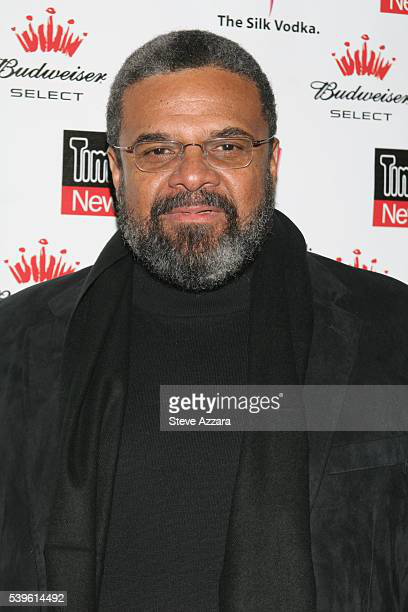

In [20]:
image_data_df.iloc[10]["image"]

In [21]:
import matplotlib.pyplot as plt

In [22]:
def get_model_info(model_ID, device):

  # Save the model to device
  model = CLIPModel.from_pretrained(model_ID).to(device)

  # Get the processor
  processor = CLIPProcessor.from_pretrained(model_ID)

  # Get the tokenizer
  tokenizer = CLIPTokenizer.from_pretrained(model_ID)

  # Return model, processor & tokenizer
  return model, processor, tokenizer

In [23]:
# Set the device
device = "cuda" if torch.cuda.is_available() else "cpu"

model_ID = "openai/clip-vit-base-patch32"

model, processor, tokenizer = get_model_info(model_ID, device)

Downloading:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/605M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/316 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/568 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/862k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/389 [00:00<?, ?B/s]

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


# Create Embeddings: Text and Image Embeddings

## Text Embeddings

In [24]:
def get_single_text_embedding(text):

  inputs = tokenizer(text, return_tensors = "pt").to(device)

  text_embeddings = model.get_text_features(**inputs)

  # convert the embeddings to numpy array 
  embedding_as_np = text_embeddings.cpu().detach().numpy()

  return embedding_as_np

In [25]:
def get_all_text_embeddings(df, text_col):

   df["text_embeddings"] = df[str(text_col)].apply(get_single_text_embedding)

   return df 

In [26]:
image_data_df = get_all_text_embeddings(image_data_df, "caption")

In [27]:
image_data_df.head()

,image_url,caption,is_valid,image,text_embeddings
0,http://lh6.ggpht.com/-IvRtNLNcG8o/TpFyrudaT6I/...,a very typical bus station,True,<PIL.Image.Image image mode=RGB size=800x534 a...,"[[0.25922304, -0.08825898, 0.020317025, -0.127..."
1,http://78.media.tumblr.com/3b133294bdc7c7784b7...,sierra looked stunning in this top and this sk...,True,<PIL.Image.Image image mode=RGB size=500x441 a...,"[[0.0041467994, 0.18943565, -0.123970225, 0.30..."
2,https://media.gettyimages.com/photos/young-con...,young confused girl standing in front of a war...,True,<PIL.Image.Image image mode=RGB size=490x612 a...,"[[-0.28737983, -0.34814143, -0.04288538, 0.401..."
3,https://thumb1.shutterstock.com/display_pic_wi...,interior design of modern living room with fir...,True,<PIL.Image.Image image mode=RGB size=450x470 a...,"[[0.56064534, -0.15138063, -0.43740302, -0.339..."
4,https://thumb1.shutterstock.com/display_pic_wi...,cybernetic scene isolated on white background .,True,<PIL.Image.Image image mode=RGB size=450x470 a...,"[[0.035292536, 0.24262792, -0.12724756, -0.210..."


## Image Embeddings

In [28]:
def get_single_image_embedding(my_image):

  image = processor(
      text = None,
      images = my_image, 
      return_tensors="pt"
  )["pixel_values"].to(device)

  embedding = model.get_image_features(image)

  # convert the embeddings to numpy array
  embedding_as_np = embedding.cpu().detach().numpy()

  return embedding_as_np

### Get the embedding of all the images

In [29]:
def get_all_images_embedding(df, img_column):

  df["img_embeddings"] = df[str(img_column)].apply(get_single_image_embedding)

  return df

In [40]:
image_data_df = get_all_images_embedding(image_data_df, "image")

In [ ]:
image_data_df.head()

,image_url,caption,is_valid,image,text_embeddings,img_embeddings
0,http://lh6.ggpht.com/-IvRtNLNcG8o/TpFyrudaT6I/...,a very typical bus station,True,<PIL.Image.Image image mode=RGB size=800x534 a...,"[[0.25922304, -0.08825898, 0.020317025, -0.127...","[[-0.0034022853, -0.053583913, 0.35247508, 0.3..."
1,http://78.media.tumblr.com/3b133294bdc7c7784b7...,sierra looked stunning in this top and this sk...,True,<PIL.Image.Image image mode=RGB size=500x441 a...,"[[0.0041467994, 0.18943565, -0.123970225, 0.30...","[[-0.25019708, -0.1325763, 0.09706805, 0.97886..."
2,https://media.gettyimages.com/photos/young-con...,young confused girl standing in front of a war...,True,<PIL.Image.Image image mode=RGB size=490x612 a...,"[[-0.28737983, -0.34814143, -0.04288538, 0.401...","[[-0.36655784, 0.3118331, -0.13266361, 0.34909..."
3,https://thumb1.shutterstock.com/display_pic_wi...,interior design of modern living room with fir...,True,<PIL.Image.Image image mode=RGB size=450x470 a...,"[[0.56064534, -0.15138063, -0.43740302, -0.339...","[[-0.17221001, -0.29784596, -0.10141284, -0.06..."
4,https://thumb1.shutterstock.com/display_pic_wi...,cybernetic scene isolated on white background .,True,<PIL.Image.Image image mode=RGB size=450x470 a...,"[[0.035292536, 0.24262792, -0.12724756, -0.210...","[[0.18897031, -0.0012195408, -0.6513251, -0.12..."


In [89]:
import matplotlib.pyplot as plt
import numpy as np

def plot_images(images):

  for image in images:
    plt.imshow(image)
    plt.show()

def plot_images_by_side(top_images):

  index_values = list(top_images.index.values)
  list_images = [top_images.iloc[idx].image for idx in index_values] 
  list_captions = [top_images.iloc[idx].caption for idx in index_values] 
  similarity_score = [top_images.iloc[idx].cos_sim for idx in index_values] 

  n_row = n_col = 2

  _, axs = plt.subplots(n_row, n_col, figsize=(12, 12))
  axs = axs.flatten()
  for img, ax, caption, sim_score in zip(list_images, axs, list_captions, similarity_score):
      ax.imshow(img)
      sim_score = 100*float("{:.2f}".format(sim_score))
      ax.title.set_text(f"Caption: {caption}\nSimilarity: {sim_score}%")
  plt.show()

# Perform Similarity Search: Cosine 

## 1. Cosine Similarity Search

In [35]:
from sklearn.metrics.pairwise import cosine_similarity

In [64]:
def get_top_N_images(query, data, top_K=4, search_criterion="text"):

    """
    Retrieve top_K (5 is default value) articles similar to the query
    """
    # Text to image Search
    if(search_criterion.lower() == "text"):
      query_vect = get_single_text_embedding(query)

    # Image to image Search
    else: 
      query_vect = get_single_image_embedding(query)

    # Relevant columns
    revevant_cols = ["caption", "image", "cos_sim"]
    
    # Run similarity Search
    data["cos_sim"] = data["img_embeddings"].apply(lambda x: cosine_similarity(query_vect, x))

    data["cos_sim"] = data["cos_sim"].apply(lambda x: x[0][0])
    
    """
    Sort Cosine Similarity Column in Descending Order 
    Here we start at 1 to remove similarity with itself because it is always 1
    """
    most_similar_articles = data.sort_values(by='cos_sim', ascending=False)[1:top_K+1]
    
    return most_similar_articles[revevant_cols].reset_index()

In [39]:
image_data_df.columns

Index(['image_url', 'caption', 'is_valid', 'image', 'text_embeddings'], dtype='object')

### a. Text to image search

In [72]:
query_caption = image_data_df.iloc[10].caption

top_images = get_top_N_images(query_caption, image_data_df)
print("Query: {}".format(query_caption))
top_images

(1, 512)
Query: actor arrives for the premiere of the film


,index,caption,image,cos_sim
0,53,actor and daughters uk premiere held,<PIL.Image.Image image mode=RGB size=640x468 a...,0.272514
1,41,pop artist attends the 3rd annual at guest house,<PIL.Image.Image image mode=RGB size=490x612 a...,0.269303
2,30,actor arrives to the premiere,<PIL.Image.Image image mode=RGB size=444x612 a...,0.247257
3,16,actor attends the premiere of season,<PIL.Image.Image image mode=RGB size=499x612 a...,0.246750


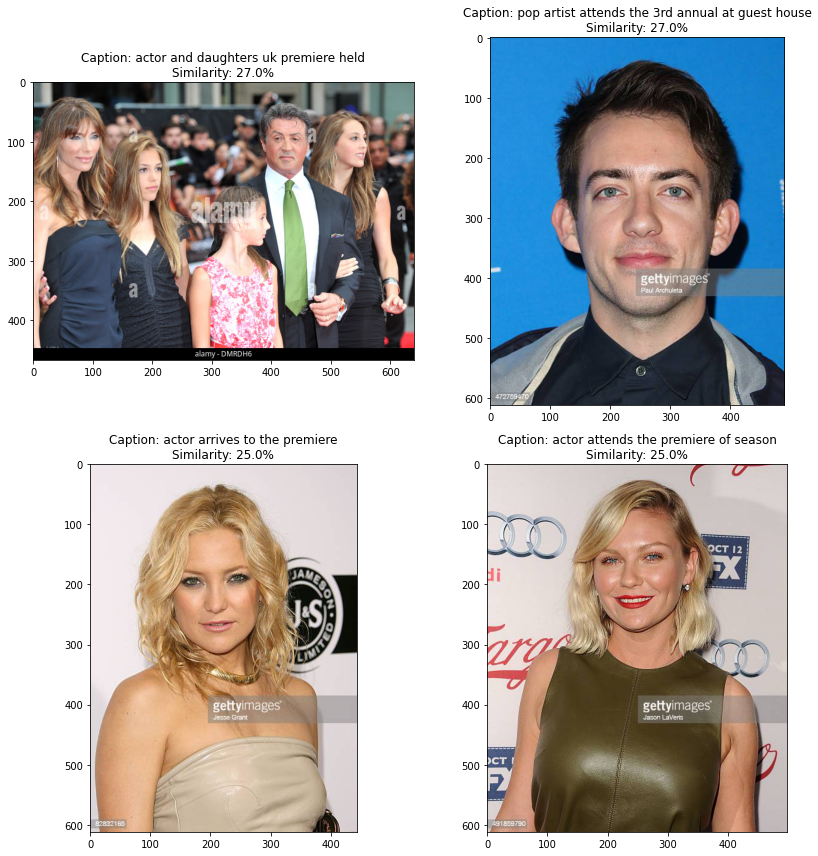

In [90]:
plot_images_by_side(top_images)

### a. Image to image search

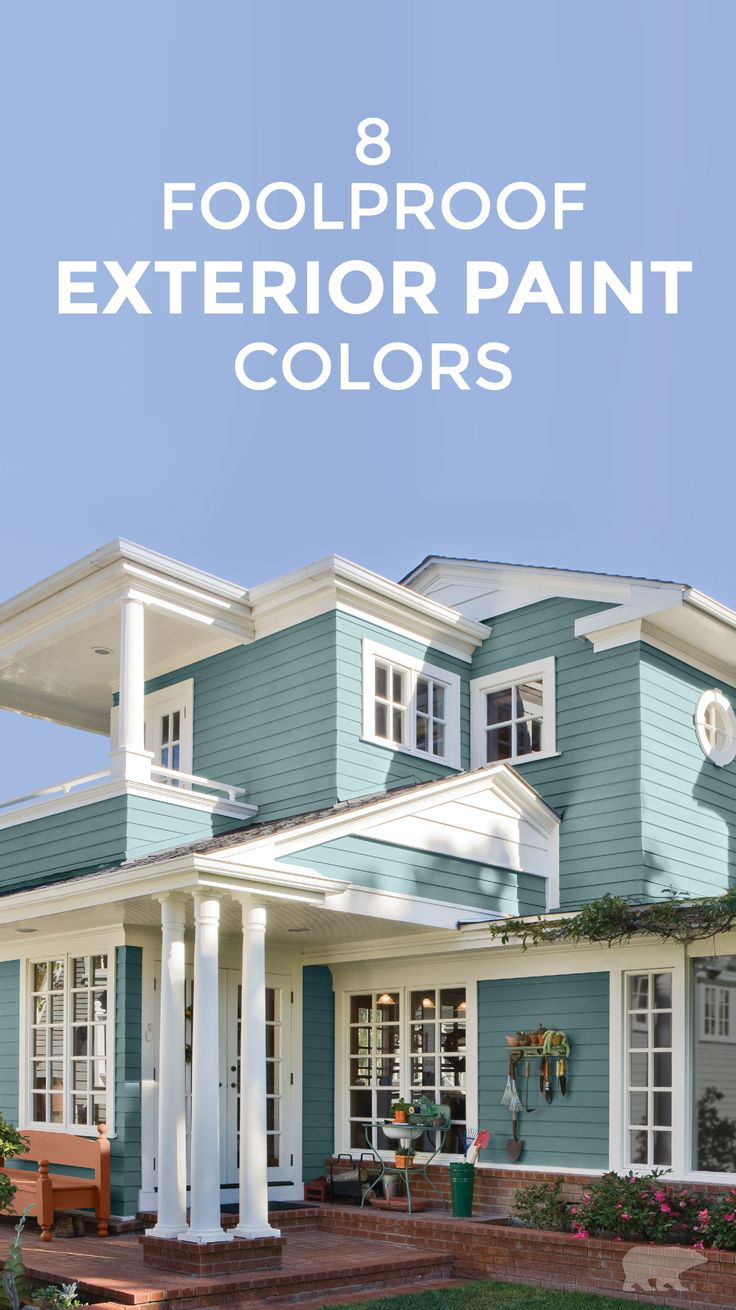

In [92]:
query_image = image_data_df.iloc[55].image
query_image

(1, 512)


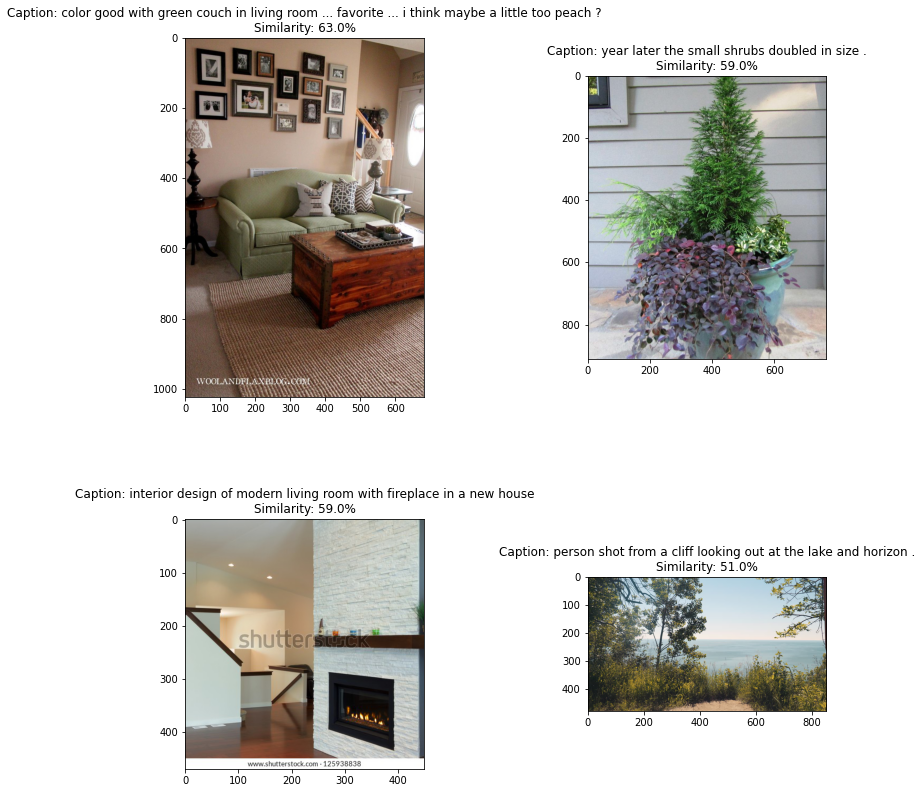

In [93]:
top_images = get_top_N_images(query_image, image_data_df, search_criterion="image")
plot_images_by_side(top_images)

## Facebook AI Similarity Search

# Approach n°2: Pinecone Client Library

## Configure the Pinecone Client

In [3]:
import pinecone

Initialize connection to Pinecone and create index. [Get free API key](https://app.pinecone.io).

In [124]:
pinecone.init(
    api_key = "<YOUR_API_KEY>",  # app.pinecone.io
    environment="us-west1-gcp"
)

my_index_name = "clip-image-search"
vector_dim = image_data_df.img_embeddings[0].shape[1]

if my_index_name not in pinecone.list_indexes():
  # Create the vectors dimension
  pinecone.create_index(name = my_index_name, 
                        dimension=vector_dim, 
                        metric="cosine", shards=1,
                        pod_type='s1.x1')

# Connect to the index
my_index = pinecone.Index(index_name = my_index_name)

Now we can check the status of the vector data

In [125]:
my_index.describe_index_stats()

{'dimension': 512,
 'index_fullness': 0.0,
 'namespaces': {},
 'total_vector_count': 0}

## Prepare Vector

In [126]:
image_data_df["vector_id"] = image_data_df.index
image_data_df["vector_id"] = image_data_df["vector_id"].apply(str)

# Get all the metadata
final_metadata = []

for index in range(len(image_data_df)):
  final_metadata.append({
      'ID':  index,
      'caption': image_data_df.iloc[index].caption, 
      'image': image_data_df.iloc[index].image_url
  })

image_IDs = image_data_df.vector_id.tolist()
image_embeddings = [arr.tolist() for arr in image_data_df.img_embeddings.tolist()] 

# Create the single list of dictionary format to insert 
data_to_upsert = list(zip(image_IDs, image_embeddings, final_metadata))

# Upload the final data
my_index.upsert(vectors = data_to_upsert)

# Check index size for each namespace
my_index.describe_index_stats()

{'dimension': 512,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 86}},
 'total_vector_count': 86}

# Start the query

### Text to image

In [1]:
text_query = image_data_df.iloc[10].caption
text_query

In [140]:
# Get the caption embedding
query_embedding = get_single_text_embedding(text_query).tolist()

In [141]:
# Run the query
my_index.query(query_embedding, top_k=4, include_metadata=True)

{'matches': [{'id': '13',
              'metadata': {'ID': 10.0,
                           'caption': 'actor arrives for the premiere of the '
                                      'film',
                           'image': 'https://media.gettyimages.com/photos/actor-john-cothran-jr-arrives-for-the-premiere-of-the-film-black-in-picture-id539614492?s=612x612'},
              'score': 0.274569482,
              'sparseValues': {},
              'values': []},
             {'id': '53',
              'metadata': {'ID': 44.0,
                           'caption': 'actor and daughters uk premiere held',
                           'image': 'http://l7.alamy.com/zooms/e163858450394e5aa21b226debd6d01f/sylvester-stallone-jennifer-flavin-and-daughters-the-expendables-2-dmrdh6.jpg'},
              'score': 0.272514,
              'sparseValues': {},
              'values': []},
             {'id': '41',
              'metadata': {'ID': 33.0,
                           'caption': 'pop artist atten

### Image to image

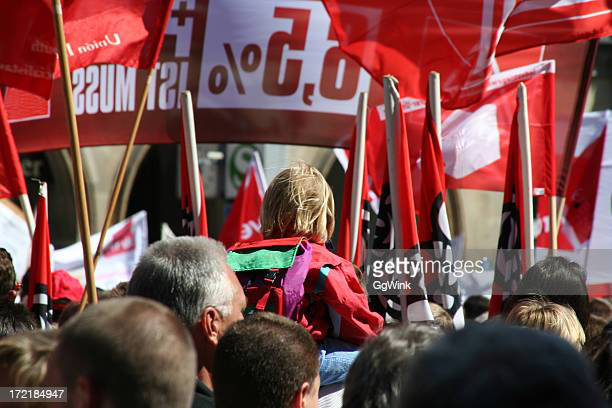

In [135]:
image_query = image_data_df.iloc[43].image
image_query

In [138]:
# Get the text embedding
query_embedding = get_single_image_embedding(image_query).tolist()

In [139]:
# Run the query
my_index.query(query_embedding, top_k=4, include_metadata=True)

{'matches': [{'id': '52',
              'metadata': {'ID': 43.0,
                           'caption': 'a demonstration of a group of people '
                                      'practicing their rights',
                           'image': 'https://media.gettyimages.com/photos/demonstration-of-a-group-of-people-practicing-their-rights-picture-id172184947?s=612x612'},
              'score': 1.0,
              'sparseValues': {},
              'values': []},
             {'id': '46',
              'metadata': {'ID': 38.0,
                           'caption': 'red and white flag on the mast',
                           'image': 'https://ak6.picdn.net/shutterstock/videos/12263756/thumb/1.jpg'},
              'score': 0.577650547,
              'sparseValues': {},
              'values': []},
             {'id': '34',
              'metadata': {'ID': 27.0,
                           'caption': 'architectural details of a bridge',
                           'image': 'https://media.getty

## Delete your index

Once finished with the index we can delete it to save resources.

In [123]:
pinecone.delete_index(my_index_name)

---